# Synthetic Clusters

## Prerequisites

Add the Congrads package to the current Colab notebook environment and install it.

In [15]:
!pip install "congrads[examples]==0.3.0"

Import the necesary functions and classes.

In [16]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from torch.optim import Adam
from torch.nn import Module, NLLLoss, Softmax
from torch.nn.modules.loss import _Loss
from torch.utils.data import Dataset
from IPython.display import clear_output

from congrads.callbacks.base import Callback, CallbackManager
from congrads.constraints.base import Constraint
from congrads.constraints.registry import (
    ImplicationConstraint,
    ScalarConstraint,
)
from congrads.core.congradscore import CongradsCore
from congrads.datasets.registry import SyntheticClusters
from congrads.descriptor import Descriptor
from congrads.metrics import MetricManager
from congrads.networks.registry import MLPNetwork
from congrads.utils.utility import (
    CSVLogger,
    Seeder,
    split_data_loaders,
)

Define utility functions for plotting and other.

In [17]:
def plot_decision_boundary(network: Module, dataset: Dataset):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Create a meshgrid over the feature space
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(next(network.parameters()).device)

    # Model prediction
    network.eval()
    with torch.no_grad():
        probs = network({"input": grid_tensor})["output"]
        Z = probs[:, 1]  # probability of class 1 (= 1 - probability of class 0)
        Z = Z.cpu().numpy().reshape(xx.shape)

    # Plot filled contour
    contour = ax.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6, vmin=0, vmax=1)
    ax.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=2)  # decision boundary
    ax.set_title("Decision Boundary")

    # Plot original data points for each class separately so they can have legend entries
    class0 = dataset.labels == 0
    class1 = dataset.labels == 1
    ax.scatter(
        dataset.data[class0, 0],
        dataset.data[class0, 1],
        c="blue",
        edgecolors="k",
        alpha=0.8,
        label="Class A",
    )
    ax.scatter(
        dataset.data[class1, 0],
        dataset.data[class1, 1],
        c="red",
        edgecolors="k",
        alpha=0.8,
        label="Class B",
    )

    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Add hatched region
    hatched_area = Rectangle(
        (0, 0),  # bottom-left corner
        0.25,  # width
        1,  # height
        facecolor="none",
        edgecolor="green",
        hatch="//",
        linewidth=1,
        alpha=0.7,
        label="Constrained region",
    )
    ax.add_patch(hatched_area)

    # Colorbar
    sm = ScalarMappable(cmap="coolwarm", norm=Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Probability of class B")
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])

    # Add legend
    ax.legend(loc="upper right", frameon=True)

    # Set limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    return ax

Define custom classes.

In [18]:
class MLPNetworkWithSoftmax(MLPNetwork):
    def __init__(
        self,
        n_inputs,
        n_outputs,
        n_hidden_layers=3,
        hidden_dim=35,
        activation=None,
    ):
        super().__init__(n_inputs, n_outputs, n_hidden_layers, hidden_dim, activation)
        self.softmax = Softmax(dim=1)

    def forward(self, batch: torch.Tensor):
        output = super().forward(batch)
        output["output"] = self.softmax(output["output"])
        return output


class NNLLossFromProb(_Loss):
    def __init__(self, size_average=None, reduce=None, reduction="mean", epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
        self.criterion = NLLLoss(size_average=size_average, reduce=reduce, reduction=reduction)

    def forward(self, input: torch.Tensor, target: torch.Tensor, **kwargs) -> torch.Tensor:
        log_probs = torch.log(torch.clamp(input, min=1e-8))
        return self.criterion(log_probs, target)

Before starting with the general training procedure, we fix the randomizer seeds and get the device on which we are training our model:



*   We have a built-in [Seeder class](https://congrads.readthedocs.io/en/latest/api.html#congrads.utils.Seeder) that will pseudo-randomly fix the seeds of random number generators, Numpy and PyTorch.
*   If there is a GPU available, use it. Otherwise fall back to CPU.



In [19]:
# Set seed for reproducibility
seeder = Seeder(base_seed=42)
seeder.set_reproducible()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Problem description

In this second example, the goal is to make a binary classification on some noisy training examples.

We aim to train a classifier that respects constraints put on the network. More specifically, for a certain part in the domain we want to enforce a high probability for class A.

Mathematically: $x \le 0.25$, then $P(\text{Blue}) \ge 0.7$

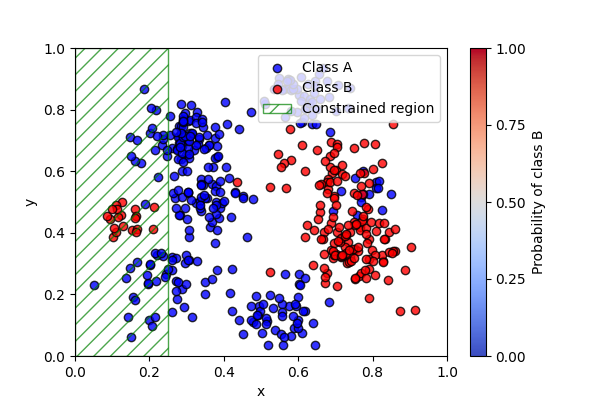

## Dataset

For this example we will use the built-in [SyntheticClusters dataset](https://) and we will split the dataset into training, validation and test sets using another [built-in utility function](https://).

In [ ]:
# Load and preprocess data
dataset = SyntheticClusters(
    cluster_centers=[
        (0.3, 0.70),
        (0.25, 0.25),
        (0.13, 0.45),
        (0.35, 0.5),
        (0.67, 0.6),
        (0.80, 0.55),
        (0.75, 0.35),
        (0.55, 0.15),
        (0.6, 0.85),
    ],
    cluster_sizes=[100, 50, 20, 50, 50, 15, 100, 50, 50],
    cluster_std=[0.06, 0.07, 0.04, 0.06, 0.07, 0.04, 0.07, 0.06, 0.06],
    cluster_labels=[0, 0, 1, 0, 1, 0, 1, 0, 0],
)
loaders = split_data_loaders(
    dataset,
    loader_args={"batch_size": 100, "shuffle": True},
    valid_loader_args={"shuffle": False},
    test_loader_args={"shuffle": False},
)

## Network

For this example we will use a slightly modified fully connected MLPNetwork with a softmax layer on the output. For this use the prepared `MLPNetworkWithSoftmax` network.

In [21]:
# Instantiate an MLPNetworkWithSoftmax, configure the parameters
network = MLPNetworkWithSoftmax(n_inputs=2, n_outputs=2, n_hidden_layers=3, hidden_dim=50)

# Push the network to the current device
network = network.to(device)


## Descriptor

Now that we have the dataset and the network defined, we can set up an important feature in the Congrads toolbox, called the `Descriptor`.

Please assign tags to all inputs and all outputs. Flag the input tags as constant.

Example:
```python
descriptor = Descriptor()
descriptor.add("input", "t", 0, constant=True)   # Assigns tag 't' to input data tensor column 0
```

Refer to the [descriptor documentation](https://congrads.readthedocs.io/en/latest/api.html#congrads.descriptor.Descriptor) for more information.


In [22]:
# Instantiate descriptor
descriptor = Descriptor()

# Add constant tags for the inputs
descriptor.add("input", "x", 0, constant=True)
descriptor.add("input", "y", 1, constant=True)

# Add variable tags for the outputs
descriptor.add("output", "ProbA", 0)
descriptor.add("output", "ProbB", 1)


## Constraints

With the help of the descriptor, we can easily reference certain parts of the neural network, and so we can now define our constraints.

We have [numerous pre-defined constraints](https://congrads.readthedocs.io/en/latest/api.html#module-congrads.constraints) available that allow a variety of options. Some examples:


*   `ScalarConstraint` allows enforcing that data referenced by a tag should be above or below a certain scalar value
* `ImplicationConstraint` allows conditionally enforcing constraints. If constraint X satisfies, then enforce constraint Y.

In this example, we want to train a classifier that respects constraints put on the network. More specifically, for a certain part in the domain we want to enforce a high probability for class A.

The objective: $x \le 0.25$, then $P(\text{Blue}) \ge 0.7$

In [23]:
# Assign descriptor to constraint base
Constraint.descriptor = descriptor

# Assign device to constraint base
Constraint.device = device

# Define constraints
constraints = [
    ImplicationConstraint(
        head=ScalarConstraint("x", "<=", 0.25),
        body=ScalarConstraint("ProbA", ">=", 0.7),
    ),
]

## Loss and optimizer

For this example, we will use a modified loss function that will first convert the predicted probabilities back into logits, and then apply an NLLLoss function to it. Use the prepared `NNLLossFromProb` for this.

We will stick to the Adam optimizer for this example.

In [24]:
# Instantiate loss criterion
criterion = NNLLossFromProb()

# Instantiate optimizer
optimizer = Adam(network.parameters(), lr=0.001)

## Metric manager

To allow keeping track of constraint satisfaction rates for each individual constraints, as well as the losses and possibly other metrics, we instantiate a metric manager.

In [25]:
# Initialize metric manager
metric_manager = MetricManager()

## Core

The [CongradsCore](https://congrads.readthedocs.io/en/latest/api.html#congrads.core.CongradsCore) is the brain of the toolbox. It orchestrates the functionality of all previously created objects, integrating descriptors, constraints, and optimization strategies to perform constraint-guided gradient descent. Essentially, it manages the full training or evaluation pipeline: preparing input and output tensors, applying constraints, computing gradients, updating model parameters, and generating predictions in a coordinated manner.

First, we define a callback that handles plotting per epoch.

Refer to the [Congrads documentation](https://congrads.readthedocs.io/en/latest/) for more info.

In [26]:
callback_manager = CallbackManager()

class PlottingCallback(Callback):
    def on_epoch_end(self, data, ctx):
        clear_output(wait=True)
        plot_decision_boundary(network, dataset)
        plt.show()
        plt.close()

callback_manager.add(PlottingCallback())

<CallbackManager callbacks=['PlottingCallback'] ctx_keys=[]>

In [27]:
# Instantiate core
core = CongradsCore(
    descriptor=descriptor,
    constraints=constraints,
    dataloader_train=loaders[0],
    dataloader_valid=loaders[1],
    dataloader_test=loaders[2],
    network=network,
    callback_manager=callback_manager,
    criterion=criterion,
    optimizer=optimizer,
    metric_manager=metric_manager,
    device=device,
    enforce_all=True,
)

Finally, we can start training by running the `core.fit(...)` function. This function allows setting the maximum epochs and callback functions and will start the training process.

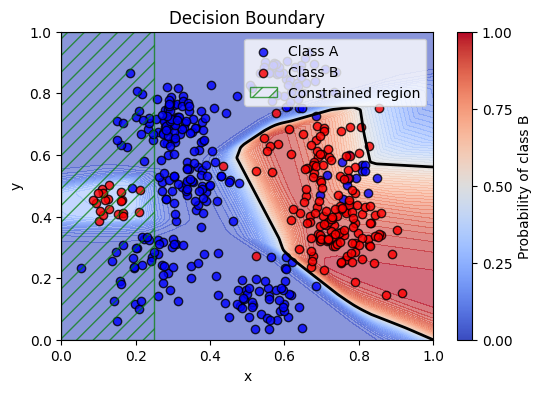

Epoch: 100%|██████████| 350/350 [03:12<00:00,  1.82it/s]


In [28]:
# Start training
core.fit(max_epochs=350)